## Data Preprocessing
Split grade data per degrees

In [ ]:
import pandas as pd

# Load grades data
grades = pd.read_csv('notes_assignatures.csv', header=None, names=[
    'Degree', 'Academic_Year', 'Student_ID', 'Gender', 'Subject', 'Subject_Code', 'Grade'
])

# Filter valid grades
grades['Grade'] = pd.to_numeric(grades['Grade'], errors='coerce')
grades.dropna(subset=['Grade'], inplace=True)

# Split by degree
grades_eng = grades[grades['Degree'].str.contains('Enginyeria Informàtica')].copy()
grades_ai = grades[grades['Degree'].str.contains('Intel·ligència Artificial')].copy()

Split occupancy data per degrees

In [32]:
# Load occupancy data (adjust for both academic years)
occupancy = pd.concat([
    pd.read_csv('ocupacio_aules_EE_23_24_v06.csv', header=None),
    pd.read_csv('ocupacio_aules_EE_24_25_v06.csv', header=None)
], ignore_index=True)

occupancy.columns = [
    'Date_Start', 'Time_Start', 'Date_End', 'Time_End', 'Duration', 'Room', 
    'Degree', 'Subject_Info', 'Enrollment_Count'
]

# Split by degree (using degree codes)
occupancy_eng = occupancy[occupancy['Degree'].str.contains('10062')].copy()  # Enginyeria Informàtica
occupancy_ai = occupancy[occupancy['Degree'].str.contains('10130')].copy()   # Intel·ligència Artificial

## Data Analysis

In [28]:
# Load grades data (all years)
grades = pd.read_csv('notes_assignatures.csv', header=None, names=[
    'Degree', 'Academic_Year', 'Student_ID', 'Gender', 'Subject', 'Subject_Code', 'Grade'
])

# Clean grades and filter valid records
grades['Grade'] = pd.to_numeric(grades['Grade'], errors='coerce')  # Handle non-numeric
grades.dropna(subset=['Grade'], inplace=True)

# Aggregate by subject (average grade, pass rate, etc.)
subject_stats = grades.groupby(['Subject', 'Subject_Code']).agg({
    'Grade': ['mean', 'median', 'count'],
    'Academic_Year': 'nunique'  # How many years the subject was taught
}).reset_index()
subject_stats.columns = ['Subject', 'Subject_Code', 'Avg_Grade', 'Median_Grade', 'Total_Students', 'Years_Taught']

In [29]:
display(grades.head())
display(subject_stats.head())

,Degree,Academic_Year,Student_ID,Gender,Subject,Subject_Code,Grade
0,Graduat en Enginyeria Informàtica,2020/21,1DFB71F2B000D1421808D0B3F67B335E,Home,Àlgebra,103801,0.0
1,Graduat en Enginyeria Informàtica,2020/21,1DFB71F2B000D1421808D0B3F67B335E,Home,Càlcul,103802,0.0
2,Graduat en Enginyeria Informàtica,2020/21,1DFB71F2B000D1421808D0B3F67B335E,Home,Electricitat i Electrònica,102771,0.0
3,Graduat en Enginyeria Informàtica,2020/21,1DFB71F2B000D1421808D0B3F67B335E,Home,Fonaments d'Enginyeria,103805,0.0
4,Graduat en Enginyeria Informàtica,2020/21,1DFB71F2B000D1421808D0B3F67B335E,Home,Fonaments d'Informàtica,103806,0.1


,Subject,Subject_Code,Avg_Grade,Median_Grade,Total_Students,Years_Taught
0,Acceleració de la Computació en IA,106592,0.000000,0.00,7,1
1,Agents Autònoms,106587,3.958333,2.50,72,2
2,Anglès Professional I,102762,8.120513,8.35,156,5
3,Anglès Professional II,102761,5.731942,7.30,139,5
4,Anàlisi de Grafs i Xarxes,106567,4.499225,6.00,129,3


In [23]:
# Load occupancy data (both years)
occupancy = pd.concat([
    pd.read_csv('ocupacio_aules_EE_23_24_v06.csv', header=None),
    pd.read_csv('ocupacio_aules_EE_24_25_v06.csv', header=None)
], ignore_index=True)

occupancy.columns = [
    'Date_Start', 'Time_Start', 'Date_End', 'Time_End', 'Duration', 'Room', 
    'Degree', 'Subject_Info', 'Enrollment_Count'
]

# Extract Subject_Code from "Subject_Info" (e.g., "103803 Estadística - 411" → 103803)
occupancy['Subject_Code'] = occupancy['Subject_Info'].str.extract(r'(\d{5,6})').astype(int)

# Clean Enrollment_Count: Convert to numeric, drop invalid rows
occupancy['Enrollment_Count'] = pd.to_numeric(occupancy['Enrollment_Count'], errors='coerce')
occupancy.dropna(subset=['Enrollment_Count'], inplace=True)

# Fix: Specify dayfirst=True and correct format
occupancy['Datetime_Start'] = pd.to_datetime(
    occupancy['Date_Start'] + ' ' + occupancy['Time_Start'], 
    dayfirst=True,  # Critical for European date formats
    format='%d/%m/%Y %H:%M'  # Explicit format to avoid ambiguity
)
# Proceed with hour/day extraction
occupancy['Hour'] = occupancy['Datetime_Start'].dt.hour
occupancy['Day_of_Week'] = occupancy['Datetime_Start'].dt.day_name()

# Aggregate occupancy by subject + time slot
occupancy_stats = occupancy.groupby(['Subject_Code', 'Hour', 'Day_of_Week']).agg({
    'Enrollment_Count': 'mean',
    'Room': 'nunique'  # How many rooms used
}).reset_index()

Matplotlib is building the font cache; this may take a moment.


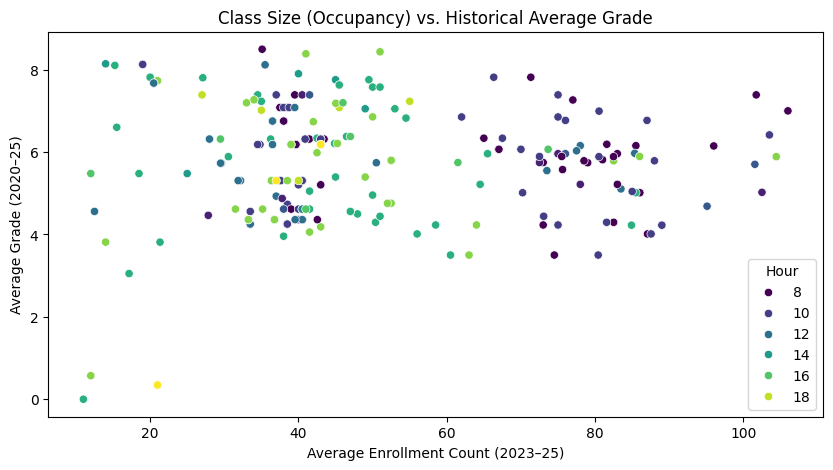

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge subject stats with occupancy stats (on Subject_Code only)
analysis_df = pd.merge(
    subject_stats,
    occupancy_stats,
    on='Subject_Code',
    how='inner'  # Only subjects with both grades and occupancy data
)

# Check if high-occupancy times correlate with better grades
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=analysis_df,
    x='Enrollment_Count',
    y='Avg_Grade',
    hue='Hour',
    palette='viridis'
)
plt.title("Class Size (Occupancy) vs. Historical Average Grade")
plt.xlabel("Average Enrollment Count (2023–25)")
plt.ylabel("Average Grade (2020–25)")
plt.show()